In [0]:
!pip install imageio

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
data_folder_path="gdrive/My Drive/Colab Notebooks/project1"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
import skimage.io
import numpy as np
import sys
from datetime import datetime
from time import time
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

log = lambda *args: print(datetime.now().strftime('%H:%M:%S'), ':', *args)


In [0]:
class Dataset(object):
    def __init__(self, X, batch_size, shuffle=False):
        self.X= X
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i + B]) for i in range(0, N, B))

In [0]:
def load_images_from_folder(folder):
    images_all_channels=[]
    i_names=[]
    for filename in sorted(os.listdir(folder)):
        img = skimage.io.imread(os.path.join(folder,filename))
        #img=cv2.imread(os.path.join(folder,filename))
        if img is not None:
            #img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            images_all_channels.append(img)
            i_names.append(filename)
    return np.asarray(images_all_channels,dtype=np.float64)

dataset=load_images_from_folder(data_folder_path+'/images/')
dataset=dataset/255
train_set,test_set=dataset[:800],dataset[-200:]

In [0]:
#load landmarks
import scipy.io
def load_landmarks_from_folder(folder):
    images = []
    lnames=[]
    for filename in sorted(os.listdir(folder)):
        img = scipy.io.loadmat(os.path.join(folder,filename))
        if img is not None:
            images.append(img['lms'].flatten())
            lnames.append(filename)
    return np.array(images),lnames
l_dataset,_=load_landmarks_from_folder(data_folder_path+'/landmarks/')
l_train_set,l_test_set=l_dataset[:800],l_dataset[-200:]
landmark_mean=l_train_set.mean(axis=0)

In [0]:
!cp 'gdrive/My Drive/Colab Notebooks/mywarper.py' mywarper.py
import mywarper
#center images
def align_image_set_to_warping(img_set,landmark_set,landmark):
  res_set=np.zeros(img_set.shape)
  for i,img in enumerate(img_set):
    res_set[i]=mywarper.warp(img,landmark_set[i].reshape(68,2),landmark.reshape(68,2))
  return res_set

train_warped=align_image_set_to_warping(train_set,l_train_set,landmark_mean)
test_warped=align_image_set_to_warping(test_set,l_test_set,landmark_mean)

In [0]:
#plt.imshow(train_warped[732])
#scale image data
#train_warped_scaled=train_warped/255
l_train_set_scaled=l_train_set/128
l_test_set_scaled=l_test_set/128

In [0]:
img_batch=tf.placeholder(tf.float32,[None,128,128,3],name="image_batch")
target=tf.placeholder(tf.float32,[None,128,128,3],name="labels")
learning_rate=tf.placeholder(tf.float32)

#encoding
x_enc0 = tf.layers.conv2d(inputs=img_batch, filters=16,kernel_size=5, strides=2,padding='SAME',activation=tf.nn.leaky_relu)
x_enc1 = tf.layers.conv2d(inputs=x_enc0, filters=32,kernel_size=3, strides=2,padding='SAME',activation=tf.nn.leaky_relu)
x_enc2 = tf.layers.conv2d(inputs=x_enc1, filters=64,kernel_size=3, strides=2,padding='SAME',activation=tf.nn.leaky_relu)
x_enc3 = tf.layers.conv2d(inputs=x_enc2, filters=128,kernel_size=3, strides=2,padding='SAME',activation=tf.nn.leaky_relu)
x_enc4 = tf.layers.conv2d(inputs=x_enc3, filters=50,kernel_size=8, strides=1,padding='VALID',activation=tf.nn.leaky_relu)
#x_enc4 = tf.contrib.layers.fully_connected(inputs=x_enc3,num_outputs=50,activation_fn=tf.nn.leaky_relu,padding="VALID")
  
#decoding
x_dec4 = tf.layers.conv2d_transpose(inputs=x_enc4, filters=128,kernel_size=8, strides=1,padding='VALID',activation=tf.nn.leaky_relu)
x_dec3 = tf.layers.conv2d_transpose(inputs=x_dec4, filters=64,kernel_size=3, strides=2,padding='SAME',activation=tf.nn.leaky_relu)
x_dec2 = tf.layers.conv2d_transpose(inputs=x_dec3, filters=32,kernel_size=3, strides=2,padding='SAME',activation=tf.nn.leaky_relu)
x_dec1 = tf.layers.conv2d_transpose(inputs=x_dec2, filters=16,kernel_size=3, strides=2,padding='SAME',activation=tf.nn.leaky_relu)
x_dec = tf.layers.conv2d_transpose(inputs=x_dec1, filters=3,kernel_size=5, strides=2,padding='SAME',activation=tf.nn.sigmoid)

images_loss=tf.losses.mean_squared_error(labels=target,predictions=x_dec)
images_cost=tf.reduce_mean(images_loss)
images_optimizer=tf.train.AdamOptimizer(learning_rate).minimize(images_cost)

In [0]:
#landmark autoencoder
landmarks_batch=tf.placeholder(tf.float32,[None,136],name="landmarks_batch")
l_target=tf.placeholder(tf.float32,[None,136],name="landmark_labels")
l_learning_rate=tf.placeholder(tf.float32)

l_x_enc0 = tf.contrib.layers.fully_connected(landmarks_batch,num_outputs=100,activation_fn=tf.nn.leaky_relu)
l_x_enc1 = tf.contrib.layers.fully_connected(l_x_enc0,num_outputs=10,activation_fn=tf.nn.leaky_relu)

l_x_dec1 = tf.contrib.layers.fully_connected(l_x_enc1,num_outputs=100,activation_fn=tf.nn.leaky_relu)
l_x_dec = tf.contrib.layers.fully_connected(l_x_dec1, num_outputs=136, activation_fn=tf.nn.sigmoid)

l_loss=tf.losses.mean_squared_error(labels=l_target,predictions=l_x_dec)
l_cost=tf.reduce_mean(l_loss)
l_optimizer=tf.train.AdamOptimizer(learning_rate).minimize(l_cost)

In [0]:
def train(sess,epochs,train_dset,l_train_dset,lr,print_every=100):
  #tf.reset_default_graph()
  #params = init_fn()
  #reduced_x = model_fn(x)#, params)  # Forward pass of the model
  #loss = training_step(scores, reduced_x, params, learning_rate)
  
  train_losses = []
  l_train_losses=[]
  
  #with tf.Session() as sess:
  for epoch in range(epochs):
    log('epoch {:>4d}/{:>4d}'.format(epoch, epochs))
    epoch_time = time()
    for t, (x_np,l_np) in enumerate(zip(train_dset,l_train_dset)):
      feed_dict={img_batch:x_np, target:x_np, learning_rate:lr,l_target:l_np,landmarks_batch:l_np}
      x_rec_,loss_np,_,l_rec_,l_loss_np,_ = sess.run([x_dec,images_loss,images_optimizer,l_x_dec,l_loss,l_optimizer], feed_dict=feed_dict)
      if t % print_every == 0:
        log('   iteration = {:>4d}, Appearance loss = {:>8.4f} Landmark loss = {:>8.4f}'.format(t, loss_np,l_loss_np))
      train_losses.append(loss_np)
      l_train_losses.append(l_loss_np)
  return x_rec_, train_losses, l_rec_,l_train_losses

In [0]:
images_train_dset = Dataset(train_warped, batch_size=64, shuffle=False)
landmark_train_dset = Dataset(l_train_set_scaled, batch_size=64, shuffle=False)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
x_rec,x_losses,l_rec,l_losses=train(sess,250,images_train_dset,landmark_train_dset,8e-4,7)

03:08:27 : epoch    0/ 250
03:08:27 :    iteration =    0, Appearance loss =   0.1460 Landmark loss =   0.0520
03:08:27 :    iteration =    7, Appearance loss =   0.1465 Landmark loss =   0.0465
03:08:28 : epoch    1/ 250
03:08:28 :    iteration =    0, Appearance loss =   0.1232 Landmark loss =   0.0371
03:08:28 :    iteration =    7, Appearance loss =   0.0547 Landmark loss =   0.0233
03:08:29 : epoch    2/ 250
03:08:29 :    iteration =    0, Appearance loss =   0.0267 Landmark loss =   0.0132
03:08:29 :    iteration =    7, Appearance loss =   0.0234 Landmark loss =   0.0063
03:08:30 : epoch    3/ 250
03:08:30 :    iteration =    0, Appearance loss =   0.0165 Landmark loss =   0.0038
03:08:30 :    iteration =    7, Appearance loss =   0.0189 Landmark loss =   0.0031
03:08:30 : epoch    4/ 250
03:08:30 :    iteration =    0, Appearance loss =   0.0145 Landmark loss =   0.0026
03:08:31 :    iteration =    7, Appearance loss =   0.0177 Landmark loss =   0.0027
03:08:31 : epoch    5/ 25

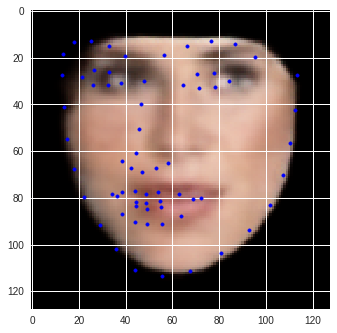

In [0]:
index=18
temp=l_rec[index]*128
plt.imshow(x_rec[index])
plt.scatter(temp.reshape(68,2)[:,0],temp.reshape(68,2)[:,1],color="b",marker=".")

In [0]:
#project test faces using autoencoder
test_faces_rec=sess.run([x_dec],feed_dict={img_batch:test_warped})[0]
#project warpings using autoencoder
l_test_rec=sess.run([l_x_dec],feed_dict={landmarks_batch:l_test_set_scaled})[0]

In [0]:
l_test_rec=l_test_rec*128

In [0]:
def reshape_generated_faces(img_set,mean,new_set):
  warped=np.zeros(img_set.shape)
  for i,img in enumerate(img_set):
    warped[i]=mywarper.warp(img,mean.reshape(68,2),new_set[i].reshape(68,2))
  return warped
test_rec_warped=reshape_generated_faces(test_faces_rec,landmark_mean,l_test_rec)

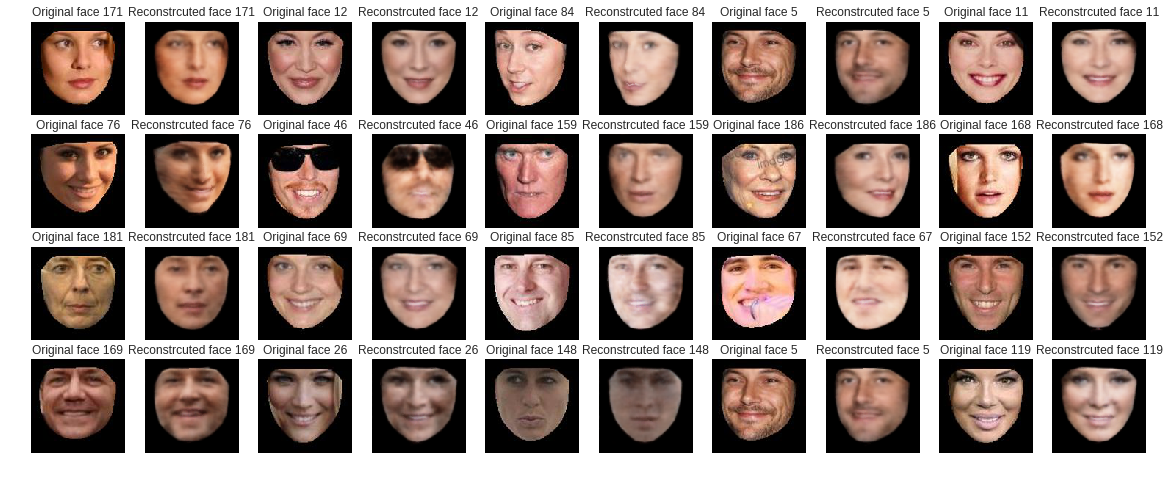

In [0]:
#part 2.1 (plot 20 faces)
def plot_faces_grid_aligned(original,reconstructed_faces,n_faces):
    n_columns=10
    plt.figure(1, figsize=(20,10))
    n_rows = math.ceil(n_faces*2 / n_columns) + 1
    j=0
    test_faces_random=np.random.randint(0,200,size=n_faces)
    for i,val in enumerate(test_faces_random):
        plt.subplot(n_rows, n_columns, j+1)
        plt.title('Original face ' + str(val+1))
        plt.axis('off')
        plt.imshow(original[val])
        plt.subplot(n_rows, n_columns, j+2)
        plt.title('Reconstrcuted face ' + str(val+1))
        plt.axis('off')
        plt.imshow(reconstructed_faces[val])
        j+=2

plot_faces_grid_aligned(test_set,test_rec_warped,20)

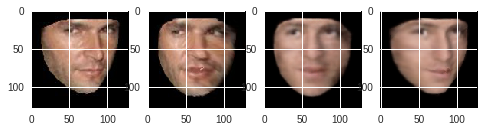

In [0]:
# index=89
# plt.subplot(1,4,1)
# plt.imshow(test_set[index])
# plt.subplot(1,4,2)
# plt.imshow(test_warped[index])
# plt.subplot(1,4,3)
# plt.imshow(test_faces_rec[index])
# plt.subplot(1,4,4)
# #temp=mywarper.warp(test_faces_rec[index],landmark_mean.reshape(68,2),l_test_rec[index].reshape(68,2))
# #plt.imshow(temp)
# plt.imshow(test_rec_warped[index])
# #plt.scatter(l_test_rec[index].reshape(68,2)[:,0],l_test_rec[index].reshape(68,2)[:,1],color="b",marker=".")

In [0]:
#interpolations
#project train faces using autoencoder
train_faces_reduced=sess.run([x_enc4],feed_dict={img_batch:train_warped})[0]
#project warpings using autoencoder
l_train_reduced=sess.run([l_x_enc1],feed_dict={landmarks_batch:l_train_set_scaled})[0]

In [0]:
def top_n_idx(l,n):
#   sort_l=sorted(l,reverse=True)[:n]
#   return np.argwhere(l>=sort_l[n-1]).flatten()
    return np.array(sorted(range(len(l)), key=lambda i: l[i], reverse=True)[:n])

In [0]:
app_variance=train_faces_reduced.var(axis=0,ddof=0)
app_variance=app_variance.flatten()
max_app_variance_idx=top_n_idx(app_variance,4)

In [0]:
landmark_variance=l_train_reduced.var(axis=0,ddof=0)
max_landmark_variance_idx=top_n_idx(landmark_variance,2)

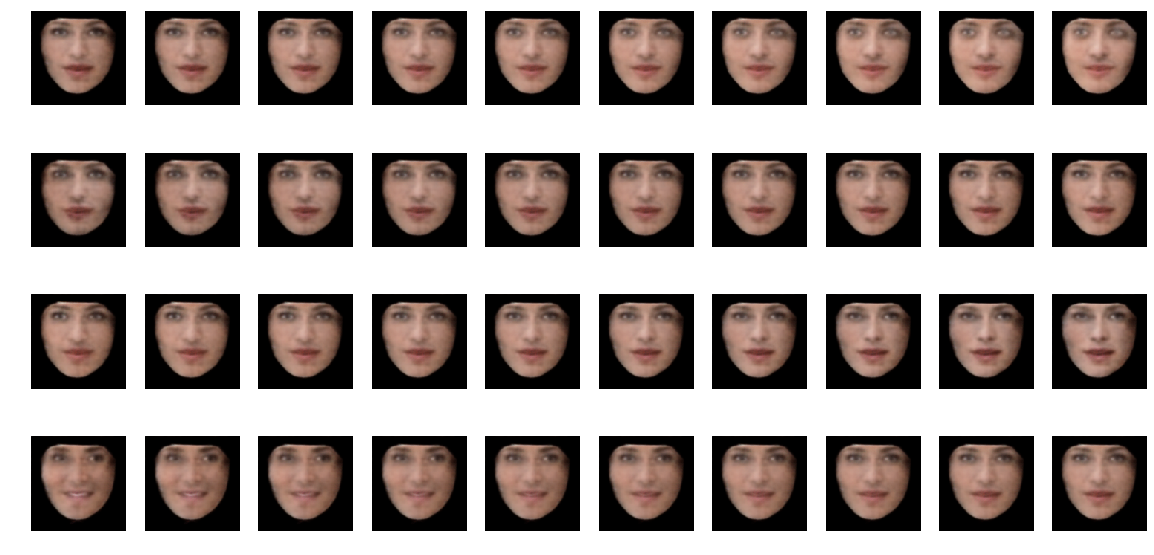

In [0]:
from copy import deepcopy

def interpolate_appearance(img_set,img_index,int_index,i_times):
  img=img_set[img_index]
  n_columns=i_times
  n_rows = int_index.shape[0]
  plt.figure(1, figsize=(20,10))
  
  #for each interpolation index
  for row,i in enumerate(int_index):
    #new image array
    int_images=np.zeros((i_times,*img.shape))
    #manipulate this interpolation index 10 times
    max_val_dim=img_set[:,:,:,i].max()
    min_val_dim=img_set[:,:,:,i].min()
    dim_int_step=(max_val_dim-min_val_dim)/(i_times*2)
    for j in range(i_times):
      new=deepcopy(img)
      new[:,:,i]=min_val_dim+((dim_int_step*j))
      int_images[j]=new
    new_img=sess.run([x_dec],feed_dict={x_enc4:int_images})[0]
    for idx,val in enumerate(new_img):
      plt.subplot(n_rows,n_columns,(idx+1)+(row*10))
      plt.imshow(val)
      plt.axis('off')
      
interpolate_appearance(train_faces_reduced,22,max_app_variance_idx,10)

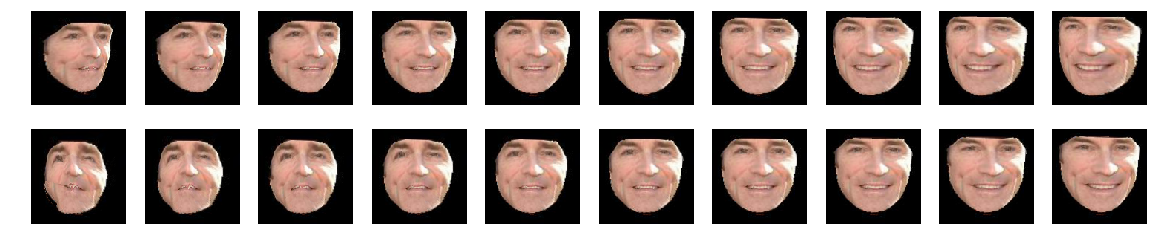

In [0]:
from copy import deepcopy

def interpolate_landmarks(img,landmarks,l_set,l_index,int_index,i_times):
  l=l_set[l_index]
  n_columns=i_times
  n_rows = int_index.shape[0]
  plt.figure(1, figsize=(20,4))
  
  #for each interpolation index
  for row,i in enumerate(int_index):
    #new image array
    int_landmarks=np.zeros((i_times,*l.shape))
    #manipulate this interpolation index 10 times
    max_val_dim=l_set[:,i].max()
    min_val_dim=l_set[:,i].min()
    dim_int_step=(max_val_dim-min_val_dim)/(i_times)
    for j in range(i_times):
      new=deepcopy(l)
      new[i]=min_val_dim+((dim_int_step*j))
      int_landmarks[j]=new
    new_l=sess.run([l_x_dec],feed_dict={l_x_enc1:int_landmarks})[0]
    new_l=new_l*128
    for idx,val in enumerate(new_l):
      warped=mywarper.warp(img,landmarks.reshape(68,2),val.reshape(68,2))
      plt.subplot(n_rows,n_columns,(idx+1)+(row*10))
      plt.imshow(warped)
      plt.axis('off')

img_index=32
interpolate_landmarks(train_set[img_index],l_train_set[img_index],l_train_reduced,img_index,max_landmark_variance_idx,10)